In [13]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import uuid
import re
import uuid
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timezone

%matplotlib inline
# %matplotlib ipympl

# Aims: QC and cleaning of downloaded river discharge data

In this notebook, we read in raw discharge data downloaded from NVE in notebook q1_get_daily_NVE_data, and then:
- Do some quick plots
- Check for NaNs. For the one river that has NaNs (Drammenselva), we patch values from Mjøndalsbru with data from further upstream (after making a quick correction of the upstream data).
- Tidy up the formatting and write only the relevant Q data to csv (i.e. dropping the usual additional NVE non-data columns).

The result is daily mean discharge data estimates from 1990 to present for all three rivers. Data pre-2005 is more uncertain for Drammenselva, where it is scaled data from Døvikfoss further upstream.

# User input

In [22]:
# Filepaths
raw_data_folder = "/Users/emma/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Thesis/data/NVE_data/discharge"

# Station coords 
station_coords = {
    "71.1.0": {"latitude": 60.85894, "longitude": 6.793},
    "72.77.0": {"latitude": 60.83693, "longitude": 7.12165},
    "73.2.0": {"latitude": 61.04416, "longitude": 7.61907},	
    "74.1.0": {"latitude": 61.24433, "longitude": 7.7182},
    "74.18.0": {"latitude": 61.23335, "longitude": 7.55117},
    "75.23.0": {"latitude": 61.34702, "longitude": 7.39822},
    "75.28.0": {"latitude": 61.38168, "longitude": 7.44511},
    "78.8.0": {"latitude": 61.4487, "longitude": 6.74268},
    "79.3.0": {"latitude": 61.15987, "longitude": 6.27839}
}

def clean_text(text, replacements):
    if text is None:
        return ""
    text = str(text)
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text


# Replacement map
replacements = {
    "æ": "ae", "ø": "o", "å": "a","√•": "å", "√Ö": "Ø", "√∏": "ø"
    }

# 
global_metadata_config = {
    "naming_authority": "no.nve",
    "project": "AquaINFRA",
    "iso_topic_category": "inlandWaters",
    "featureType": "timeSeries",
    "spatial_representation": "point",
    "creator_type": "institution",
    "creator_institution": "Norwegian Institute for Water Research (NIVA)",
    "institution": "Norwegian Institute for Water Research (NIVA)",
    "institution_short_name": "NIVA",
    "creator_name": "Leah Jackson-Blake",
    "creator_email": "leah.jackson-blake@niva.no",
    "creator_url": "https://www.niva.no/en/employees/leah-amber-jackson-blake?result_count=68",
    "data_owner": "Norwegian Institute for Water Research",
    "source": "NVE HydAPI (https://hydapi.nve.no/)",
    "processing_level": "Cleaned and harmonized daily discharge",
    "Conventions": "CF-1.7, ACDD-1.3",
    "publisher_name": "Norwegian Institute for Water Research",
    "publisher_email": "miljoinformatikk@niva.no",
    "publisher_institution": "Norwegian Institute for Water Research",
    "publisher_url": "https://niva.no",
    "license": "http://spdx.org/licenses/CC-BY-4.0(CC-BY-4.0)",
    "keywords": "GCMD:EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER, GCMDLOC:CONTINENT > EUROPE > NORWAY",
    "keywords_vocabulary": "GCMD:GCMD Science Keywords, GCMDLOC:GCMD Locations",
    "history": (
        "2024-08-28 - Data retrieved from NVE HydAPI with 1440-minute resolution.\n"
        "Data filtered to start from 1990-01-01.\n"
        "Timestamps normalized to daily frequency and made timezone-naive.\n"
        "Discharge values rounded to 3 decimal places.\n"
    )
}

processed_namespace_uuid = uuid.uuid5(uuid.NAMESPACE_DNS, "aquainfra.niva.no")

# Where to save
out_data_folder = "/Users/emma/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Thesis/data/NVE_data/discharge/clean"
os.makedirs(out_data_folder, exist_ok=True)

fig_folder = "/Users/emma/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Thesis/data/NVE_data/discharge/figures"
os.makedirs(fig_folder, exist_ok=True)

# Read in data

Data download done in notebook q1_get_daily_NVE_data

In [23]:
data_dict = {}  # key: (river, station_name, station_id)

for file in glob.glob(os.path.join(raw_data_folder, "Q_daily-mean_*.csv")):
    
    # Extract parts from filename
    filename = os.path.basename(file)
    parts = filename.split('_')
    riverName = parts[2].translate(replacements)
    station_name = parts[3].translate(replacements)
    station_id = parts[4].split('.')[0]  # remove .csv extension

    # Read CSV instead of xr.open_dataset
    df = pd.read_csv(file)

    # Clean text columns if present
    if "station_name" in df.columns:
        df["station_name"] = df["station_name"].str.translate(replacements)
    if "riverName" in df.columns:
        df["riverName"] = df["riverName"].str.translate(replacements)
        
    # Store dataframe in dict
    data_dict[(riverName, station_name, station_id)] = df

In [24]:
# Make a little site metadata df for plot naming later
site_df = pd.DataFrame(data_dict.keys(), columns=['riverName', 'station_name', 'station_id'])
site_df

,riverName,station_name,station_id
0,Nessedalselv,Nessedalselv,79
1,Krokenelv,Krokenelv,75
2,Stuvane,Stuvane,73
3,Årdalsvatn,Årdalsvatn,74
4,Skjerping,Skjerping,71
5,Flåm bru,Flåm bru,72
6,Feigumfoss,Feigumfoss,75
7,Fornabu,Fornabu,74
8,Bøyumselv,Bøyumselv,78


# Quick plots

## Whole series 2018-2023

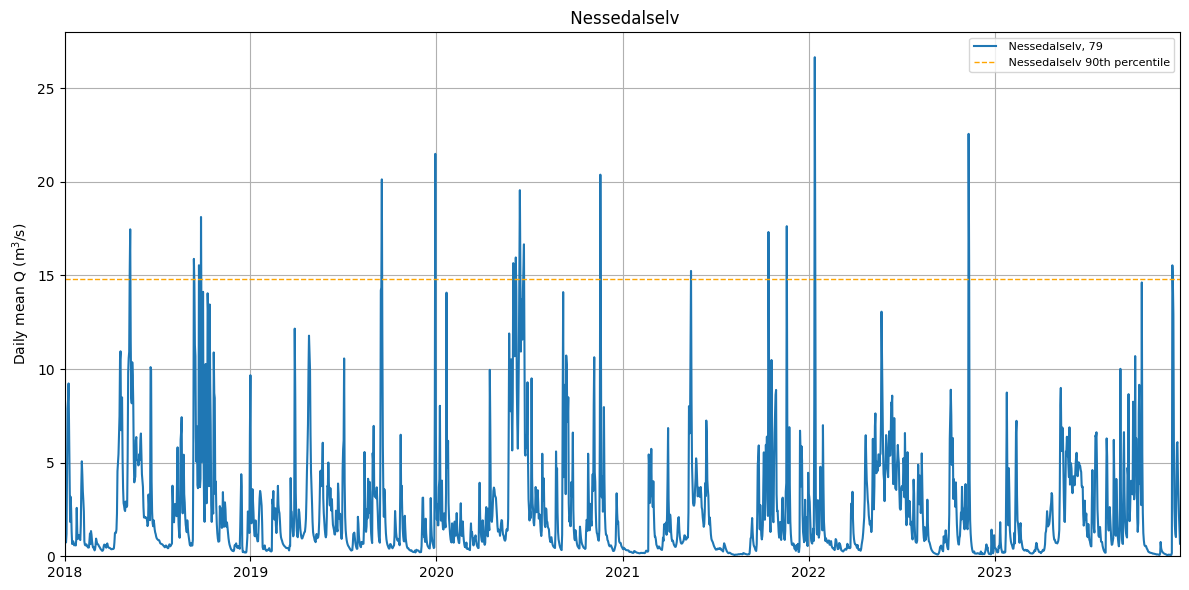

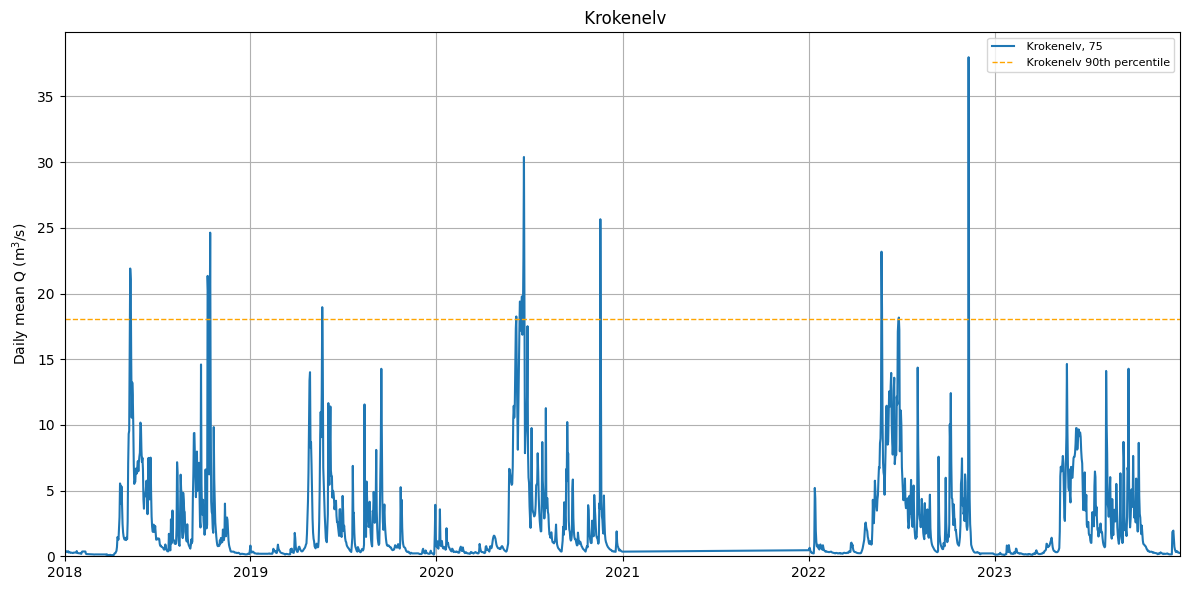

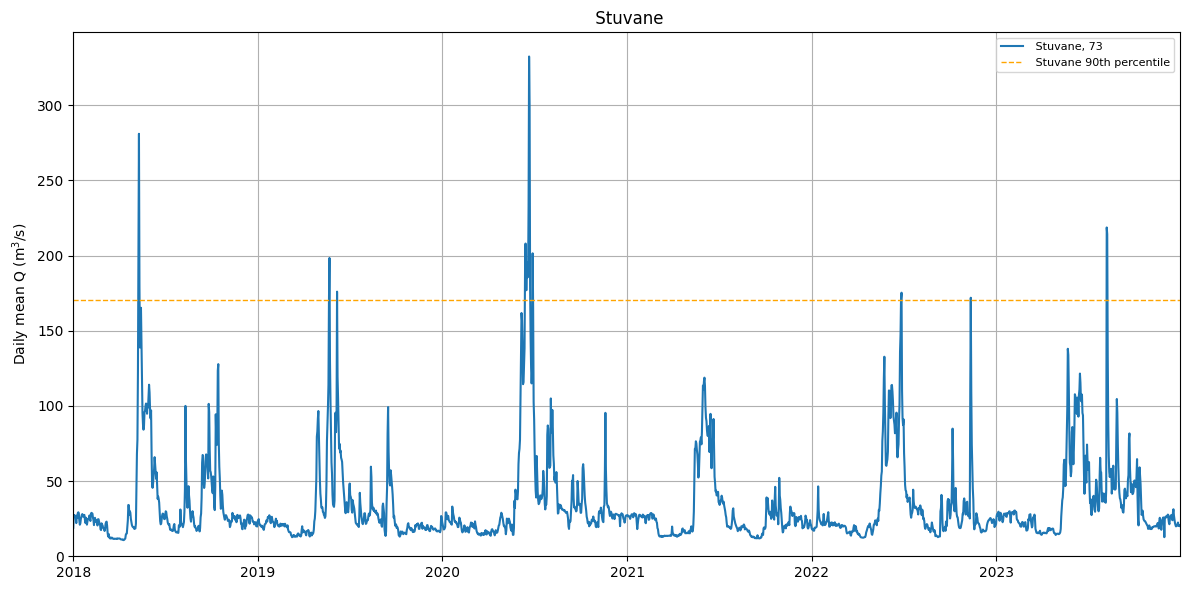

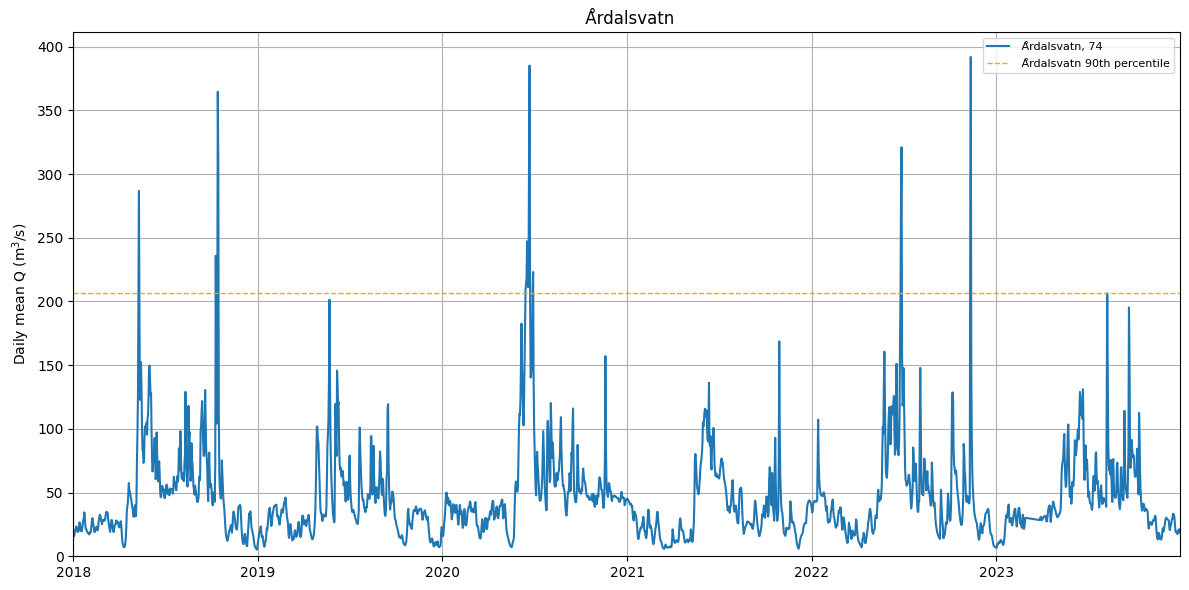

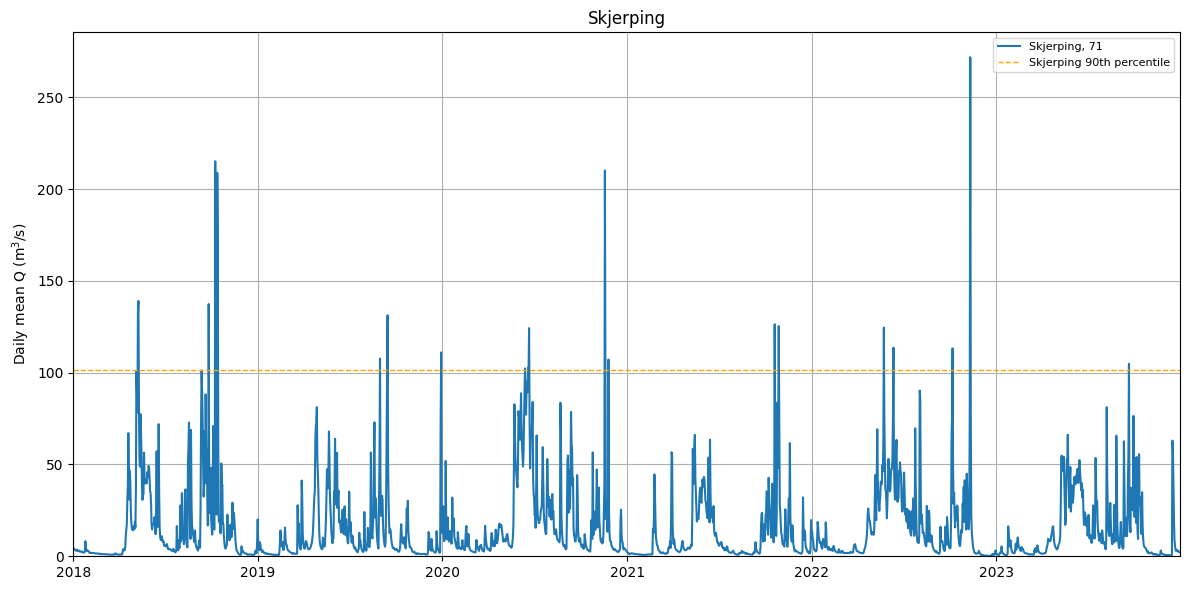

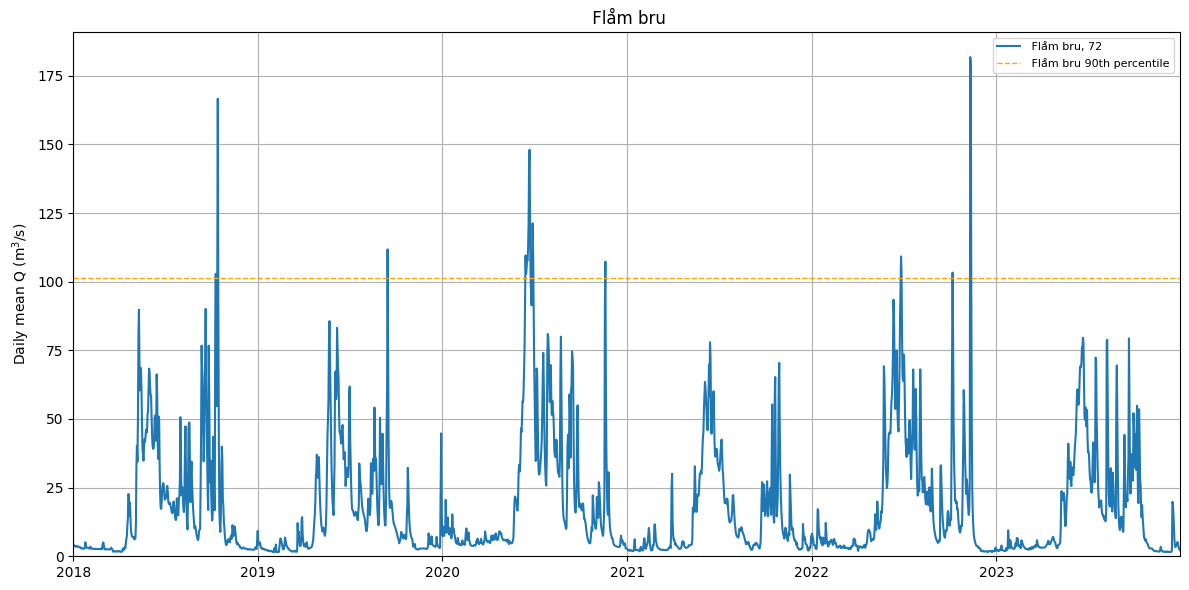

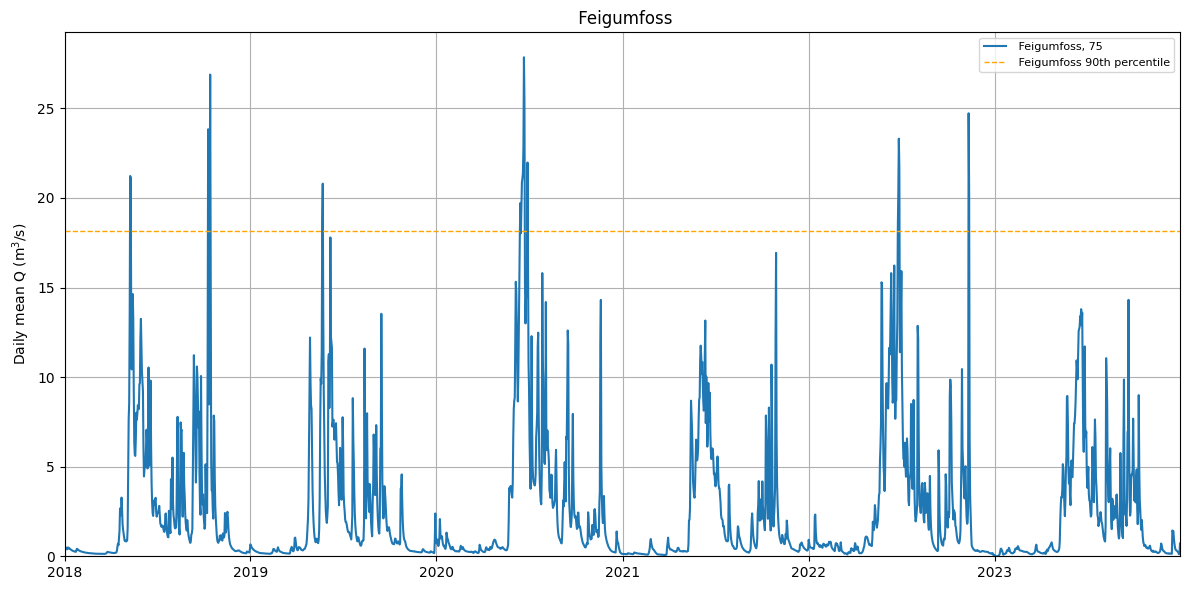

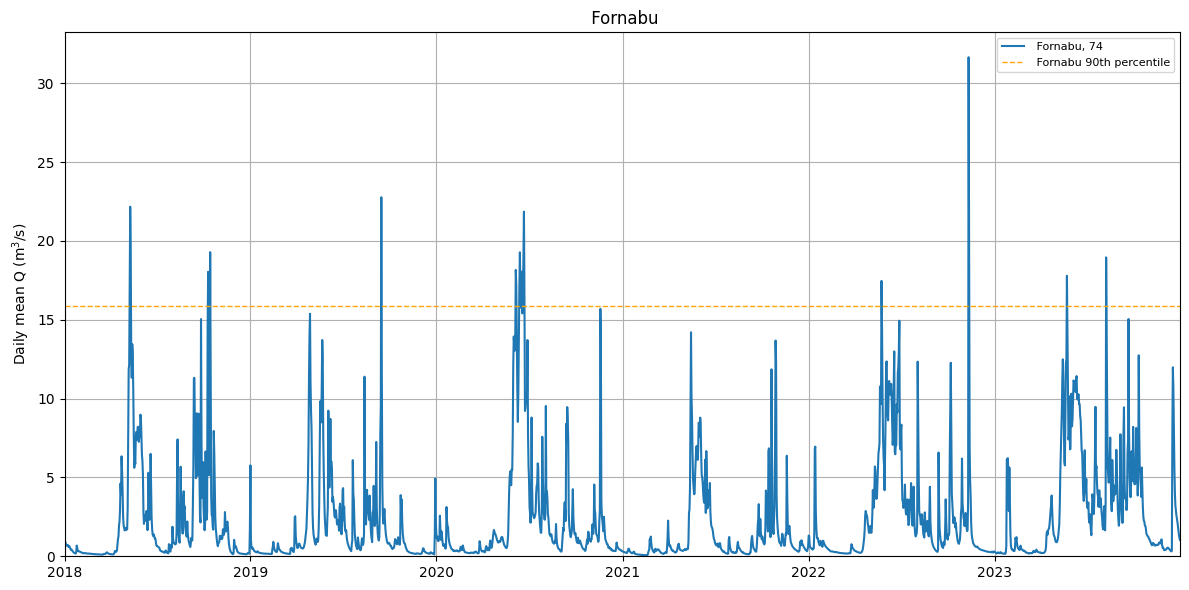

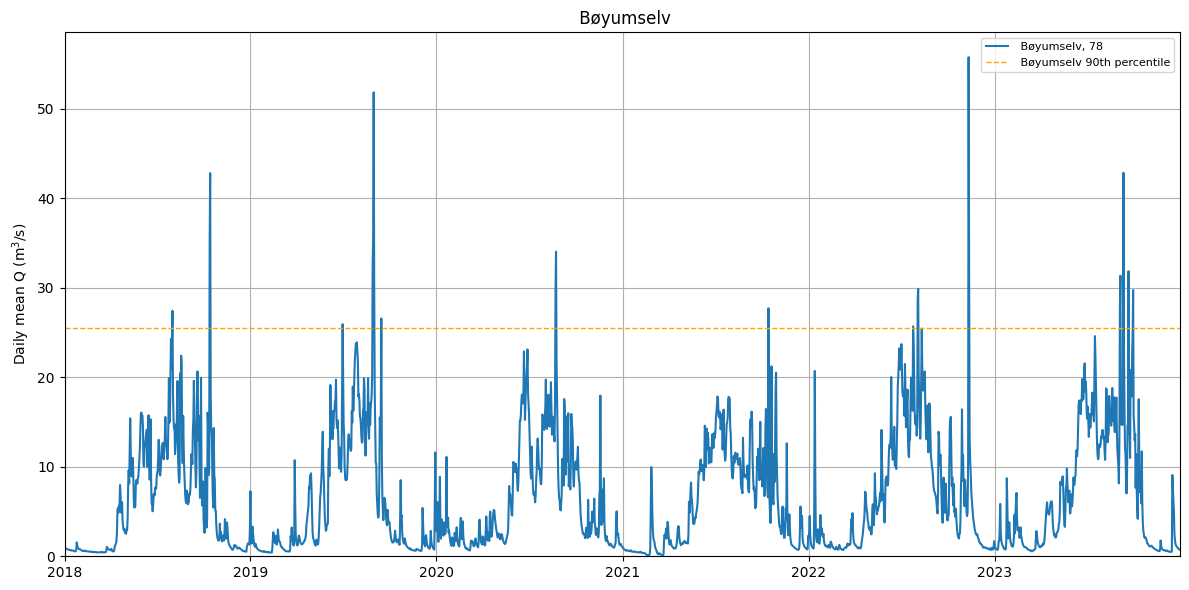

In [25]:
riv_li = site_df['riverName'].unique()

# Plot loop
for river in riv_li:
    fig, ax = plt.subplots(figsize=(12, 6))
    riv_df = site_df[site_df['riverName'] == river]

    for _, row in riv_df.iterrows():
        station_name = row['station_name']
        station_id = row['station_id']

        df = data_dict.get((river, station_name, station_id))
        if df is None or df["value"].isna().all():
            print(f"Skipping {station_name}, {station_id} (no data)")
            continue

        # Convert to datetime and normalize to daily precision
        df["datetime"] = pd.to_datetime(df["datetime"])
        df["datetime"] = df["datetime"].dt.normalize()
        df.set_index("datetime", inplace=True)

        # Ensure numeric
        df["value"] = pd.to_numeric(df["value"], errors="coerce")

        # Slice 2018–2023
        df_plot = df.loc["2018-01-01":"2023-12-31", "value"].dropna()

        if df_plot.empty:
            print(f"No data for {station_name}, {station_id} in 2018–2023")
            continue

        # --- NEW: Add a 90th percentile line ---
        perc = df_plot.quantile(0.99)

        # Plot the time series
        ax.plot(df_plot.index, df_plot.values, label=f"{station_name}, {station_id}", linewidth=1.5)

        # Add horizontal 90th percentile line (faint dashed line)
        ax.axhline(perc, color='orange', linestyle='--', linewidth=1,
                   label=f"{station_name} 90th percentile")

    # --- Plot styling ---
    ax.grid(True)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=pd.Timestamp("2018-01-01"), right=pd.Timestamp("2023-12-31"))
    ax.set_xlabel('')
    ax.set_ylabel('Daily mean Q (m$^3$/s)')
    ax.set_title(river)

    # Add global legend (avoid duplicates)
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), fontsize=8)

    plt.tight_layout()

    # Save figure
    fpath = os.path.join(fig_folder, f"Q_raw_timeseries_2018-2023_{river}.png")
    plt.savefig(fpath, dpi=300)
    plt.show()


## Plot year by year

In [ ]:
def plot_year_by_year(start_year, end_year, df):
    yr_list = list(range(start_year, end_year+1))
    n_yrs = len(yr_list)
    fig, axs = plt.subplots(n_yrs, 1, figsize=(10, n_yrs * 2.5), sharey=True)

    for i, year in enumerate(yr_list):
        df['value'].loc[f'{year}-01-01':f'{year}-12-31'].plot(ax=axs[i])
        axs[i].grid(True)
        # Format x-axis to show month only (year is in the subplot title)
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

        # Sort out tick labels (unrotate and re-centre)
        axs[i].tick_params(axis='x', rotation=0)
        for label in axs[i].get_xticklabels():
            label.set_ha('center')

        axs[i].set_xlabel('')
        axs[i].set_ylabel('Q (m$^3$/s)')
        axs[i].set_title(year)

    plt.suptitle(df['station_name'].iloc[0])

    plt.tight_layout(rect=[0, 0, 1, 0.99])  # Adjust the rect parameter to add padding
    plt.show()

In [ ]:
for key in data_dict.keys():
    df = data_dict[key]
    plot_year_by_year(2018, 2023, df)

# Fill NaNs

To estimate freshwater fluxes to the Oslofjord we need complete time series of freshwater flows. Here, we check for NaNs, and then if any are present fill them by patching or interpolating.

In [6]:
# Check for NaNs
for key, df in data_dict.items():
    print(key)
    # Remove data pre-1990
    df = df.loc["1990":, :]

    # Convert to daily frequency (if isn't already)
    df = df.asfreq('D')

    # Count number of NaNs since 1990
    nan_count = df['value'].isna().sum()
    print(f"Number of NaNs: {nan_count}")

    # Calculate the number of data gaps
    df['gap_start'] = df['value'].notna().astype(int).diff().fillna(0) == -1
    num_gaps = df['gap_start'].sum()
    print(f"Number of data gaps: {num_gaps}")

    # Calculate the length of the longest data gap (in days)
    df['gap'] = df['value'].isna().astype(int).groupby(df['value'].notna().astype(int).cumsum()).cumsum()
    longest_gap = df['gap'].max()
    print(f"Longest data gap: {longest_gap} days\n")

(' Nessedalselv', ' Nessedalselv', '79')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days

(' Krokenelv', ' Krokenelv', '75')
Number of NaNs: 365
Number of data gaps: 1
Longest data gap: 365 days

(' Stuvane', ' Stuvane', '73')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days

(' Årdalsvatn', ' Årdalsvatn', '74')
Number of NaNs: 27
Number of data gaps: 1
Longest data gap: 27 days

('Skjerping', 'Skjerping', '71')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days

(' Flåm bru', ' Flåm bru', '72')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days

(' Feigumfoss', ' Feigumfoss', '75')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days

(' Fornabu', ' Fornabu', '74')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days

(' Bøyumselv', ' Bøyumselv', '78')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days



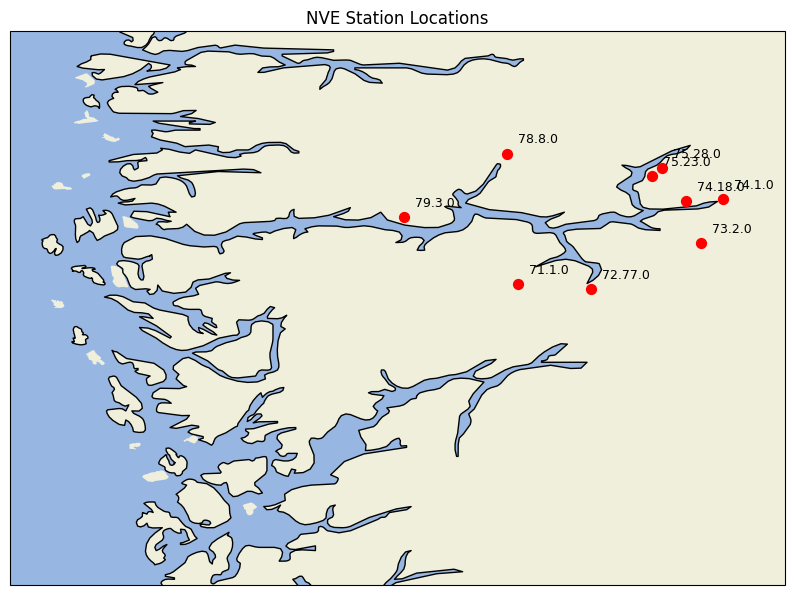

In [26]:
# Prepare station DataFrame
stations = []
for station_id, coords in station_coords.items():
    river_name = site_df.loc[site_df['station_id'] == station_id, 'riverName']
    river_name = river_name.values[0] if len(river_name) > 0 else "Unknown"
    
    stations.append({
        "station_id": station_id,
        "riverName": river_name,
        "latitude": coords["latitude"],
        "longitude": coords["longitude"]
    })

stations_df = pd.DataFrame(stations)

# Create plot
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot stations
ax.scatter(stations_df["longitude"], stations_df["latitude"], color='red', s=50, zorder=5)

# Annotate station IDs
for i, row in stations_df.iterrows():
    ax.text(row["longitude"] + 0.05, row["latitude"] + 0.05, row["station_id"], fontsize=9)

# Set extent [lon_min, lon_max, lat_min, lat_max] for Norway region
ax.set_extent([4.5, 8.0, 59.5, 62.0])

plt.title("NVE Station Locations")
plt.show()
